In [1]:
import pandas as pd
import numpy as np
import mibian
import time
import datetime

In [17]:
options1_df = pd.read_csv('../yahooData/results/finalData_3-11.csv', delimiter=',', engine='python')
options2_df = pd.read_csv('../yahooData/results/finalData_3-18.csv', delimiter=',', engine='python', encoding= 'unicode_escape')
options3_df = pd.read_csv('../yahooData/results/finalData_3-25.csv', delimiter=',', engine='python', encoding= 'unicode_escape')
options4_df = pd.read_csv('../yahooData/results/finalData_4-01.csv', delimiter=',', engine='python', encoding= 'unicode_escape')
options5_df = pd.read_csv('../yahooData/results/finalData_4-08.csv', delimiter=',', engine='python', encoding= 'unicode_escape')
options6_df = pd.read_csv('../yahooData/results/finalData_4-15.csv', delimiter=',', engine='python', encoding= 'unicode_escape')
options7_df = pd.read_csv('../yahooData/results/finalData_4-22.csv', delimiter=',', engine='python', encoding= 'unicode_escape')


In [18]:
def process_data(df, symbol, sector, call):
    # Let's take a look at appl calls and puts
    symbol_df = df[df.Sector==symbol] if sector else df[df.Symbol==symbol] 
    symbol_df = symbol_df[symbol_df['Call'] == 1] if call else symbol_df[symbol_df['Call'] == 0]
    symbol_df.columns = symbol_df.columns.str.strip()

    symbol_df = symbol_df.replace({'In the Money': {'True':1, 'False':0}})
    symbol_df = symbol_df.replace({'In the Money': {True:1, False:0}})
    symbol_df = symbol_df.replace({'Call': {True:1,False:0}})

    # columns to drop for our input feature vector
    columns = ['Symbol','Expiration Date', 'Sector', 'Industry', 'Record Time', 'Profit', 'Call']
    symbol_df = symbol_df.drop(columns=columns)
    
    failed_len = len(symbol_df[symbol_df['Success'] == 0])
    
    count = len(symbol_df[symbol_df['Success'] == 1])
    if count < failed_len:
        count_failed = count * 3 if failed_len > count * 3 else count * 2
        count_failed = count_failed if failed_len > count_failed else count
    else:
        count_failed = failed_len
    
    failed_df = symbol_df.loc[symbol_df['Success'] == 0].sample(n=count_failed,random_state=42)
    success_df = symbol_df.loc[symbol_df['Success'] == 1]
    
    return pd.concat([failed_df, success_df])

In [19]:
print(options1_df.shape, options2_df.shape, options3_df.shape, options4_df.shape, options5_df.shape, options6_df.shape, options7_df.shape)
options1c_df = process_data(options1_df, 'Technology', True, True)
options2c_df = process_data(options2_df, 'Technology', True, True)
options3c_df = process_data(options3_df, 'Technology', True, True)
options4c_df = process_data(options4_df, 'Technology', True, True)
options5c_df = process_data(options5_df, 'Technology', True, True)
options6c_df = process_data(options6_df, 'Technology', True, True)
options7c_df = process_data(options7_df, 'Technology', True, True)

calls_df = pd.concat([options1c_df, options2c_df, options3c_df, options4c_df, options5c_df])
options7call_df = pd.concat([options6c_df, options7c_df])

print(options1c_df.shape, options2c_df.shape, options3c_df.shape, options4c_df.shape, options5c_df.shape, options6c_df.shape, options7c_df.shape)

options1p_df = process_data(options1_df, 'Technology', True, False)
options2p_df = process_data(options2_df, 'Technology', True, False)
options3p_df = process_data(options3_df, 'Technology', True, False)
options4p_df = process_data(options4_df, 'Technology', True, False)
options5p_df = process_data(options5_df, 'Technology', True, False)
options6p_df = process_data(options6_df, 'Technology', True, False)
options7p_df = process_data(options7_df, 'Technology', True, False)

puts_df = pd.concat([options1p_df, options2p_df, options3p_df, options4p_df, options5p_df])
options7put_df = pd.concat([options6p_df, options7p_df])

print(options1p_df.shape, options2p_df.shape, options3p_df.shape, options4p_df.shape, options5p_df.shape, options6p_df.shape, options7p_df.shape)



(18835, 18) (70267, 18) (38263, 18) (51372, 18) (57275, 18) (150491, 18) (31149, 18)
(100, 11) (7176, 11) (3510, 11) (3792, 11) (884, 11) (1796, 11) (252, 11)
(1860, 11) (6728, 11) (844, 11) (5052, 11) (5604, 11) (16040, 11) (3044, 11)


In [11]:
# frames = [options1_df, options2_df, options3_df, options4_df, options5_df]

# options_df = pd.concat(frames)

# options7_df = pd.concat([options6_df, options7_df])

Index(['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Success'],
      dtype='object')


In [20]:
def categorise(row):
    return ((row['Final Price'] - row['Current Price']) / row['Current Price']) * 100

calls_df['Actual Percent Change'] = calls_df.apply(lambda row: categorise(row), axis=1)
options7call_df['Actual Percent Change'] = options7call_df.apply(lambda row: categorise(row), axis=1)

puts_df['Actual Percent Change'] = puts_df.apply(lambda row: categorise(row), axis=1)
options7put_df['Actual Percent Change'] = options7put_df.apply(lambda row: categorise(row), axis=1)

In [23]:
def callDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callDelta

def callTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callTheta

def callRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callRho

def callVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def callGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

def putDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putDelta

def putTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putTheta

def putRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putRho

def putVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def putGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

In [24]:
start_time = time.time()

calls_df['Delta'] = calls_df.apply(lambda row: callDelta(row), axis=1)
calls_df['Theta'] = calls_df.apply(lambda row: callTheta(row), axis=1)
calls_df['Rho'] = calls_df.apply(lambda row: callRho(row), axis=1)
calls_df['Vega'] = calls_df.apply(lambda row: callVega(row), axis=1)
calls_df['Gamma'] = calls_df.apply(lambda row: callGamma(row), axis=1)

options7call_df['Delta'] = options7call_df.apply(lambda row: callDelta(row), axis=1)
options7call_df['Theta'] = options7call_df.apply(lambda row: callTheta(row), axis=1)
options7call_df['Rho'] = options7call_df.apply(lambda row: callRho(row), axis=1)
options7call_df['Vega'] = options7call_df.apply(lambda row: callVega(row), axis=1)
options7call_df['Gamma'] = options7call_df.apply(lambda row: callGamma(row), axis=1)

puts_df['Delta'] = puts_df.apply(lambda row: putDelta(row), axis=1)
puts_df['Theta'] = puts_df.apply(lambda row: putTheta(row), axis=1)
puts_df['Rho'] = puts_df.apply(lambda row: putRho(row), axis=1)
puts_df['Vega'] = puts_df.apply(lambda row: putVega(row), axis=1)
puts_df['Gamma'] = puts_df.apply(lambda row: putGamma(row), axis=1)

options7put_df['Delta'] = options7put_df.apply(lambda row: putDelta(row), axis=1)
options7put_df['Theta'] = options7put_df.apply(lambda row: putTheta(row), axis=1)
options7put_df['Rho'] = options7put_df.apply(lambda row: putRho(row), axis=1)
options7put_df['Vega'] = options7put_df.apply(lambda row: putVega(row), axis=1)
options7put_df['Gamma'] = options7put_df.apply(lambda row: putGamma(row), axis=1)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

Took 0:05:48.735887 seconds


In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import make_scorer, precision_score

start_time = time.time()

parameters = {'kernel':['rbf'], 'C':[100, 10, 1], 'gamma': [0.1, 0.001, 0.00001]}
scoring = {'precision': make_scorer(precision_score, average = 'macro')}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = scoring, refit='precision')
clf.fit(calls_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1), calls_df.filter(['Success'], axis=1).values.ravel())

print(clf.best_params_, clf.best_score_)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

{'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'} 0.7961467280833703
Took 0:05:09.584583 seconds


In [126]:
start_time = time.time()

parameters = {'kernel':['rbf'], 'C':[100, 10, 1], 'gamma': [0.1, 0.001, 0.00001]}
scoring = {'precision': make_scorer(precision_score, average = 'macro')}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = scoring, refit='precision')
clf.fit(puts_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1), puts_df.filter(['Success'], axis=1).values.ravel())

print(clf.best_params_, clf.best_score_)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

{'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'} 0.7704149449101688
Took 0:11:47.021773 seconds


In [128]:
start_time = time.time()

parameters = {'kernel':['rbf'], 'C':[100, 10], 'gamma': [0.1, 0.01, 0.001, 0.00001]}
scoring = {'precision': make_scorer(precision_score, average = 'macro')}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = scoring, refit='precision')
clf.fit(calls_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1), calls_df.filter(['Success'], axis=1).values.ravel())

print(clf.best_params_, clf.best_score_)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

/Users/dingew/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dingew/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dingew/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dingew/opt/anaconda3/lib/python3.8/site-packages

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'} 0.8079378783288057
Took 0:04:05.573712 seconds


In [112]:
start_time = time.time()

parameters = {'kernel':['rbf'], 'C':[100, 10], 'gamma': [0.1, 0.01, 0.001, 0.00001]}
scoring = {'precision': make_scorer(precision_score, average = 'macro')}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = scoring, refit='precision')
clf.fit(puts_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1), puts_df.filter(['Success'], axis=1).values.ravel())

print(clf.best_params_, clf.best_score_)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.845 total time=  10.6s
[CV 2/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.798 total time=  10.9s
[CV 3/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.763 total time=  11.0s
[CV 4/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.667 total time=  10.1s
[CV 5/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.831 total time=  12.0s
[CV 1/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.843 total time=  11.0s
[CV 2/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.802 total time=  10.2s
[CV 3/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.763 total time=  10.9s
[CV 4/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.672 total time=   9.4s
[CV 5/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.831 total time=  11.0s
[CV 1/5] END ....C=100, gamma=1e-05, kernel=rbf;, score=0.831 total time=  12.3s
[CV 2/5] END ....C=100, gamma=1e-05, kernel=rbf;,

In [87]:
trainX = calls_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1)
trainY = calls_df.filter(['Success'], axis=1)

testX = options7call_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1)
testY = options7call_df.filter(['Success'], axis=1)

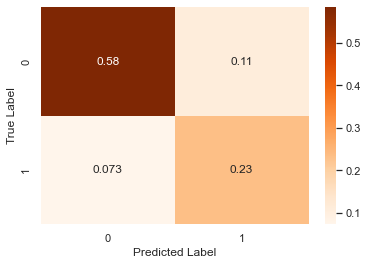

,Metric:,Results:
0,Precision,0.727680
1,Recall,0.801432
2,F1,0.723496
3,Accuracy,0.747070
4,Profitability,-5723.185000
5,Profit Percent,-11.783795


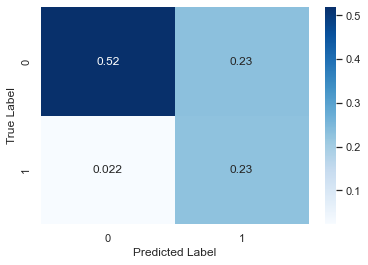

Took 0:00:17.913936 seconds


In [104]:
from sklearn.metrics import precision_recall_fscore_support
start_time = time.time()

model = SVC(C= 100, kernel='rbf', gamma = 0.00001)
model.fit(trainX, trainY.to_numpy().flatten())
trainPredict = model.predict(trainX)
cfMatrixTrain = confusion_matrix(trainY, trainPredict)
ax = sns.heatmap(cfMatrixTrain/np.sum(cfMatrixTrain), annot=True, cmap='Oranges')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

testPredict = model.predict(testX)
cfMatrixTest = confusion_matrix(testY, testPredict)

score = model.score(testX, testY)
prec = list(precision_recall_fscore_support(testY, testPredict, average='macro'))
prec[-1] = score


profitTestX = options7call_df.copy()
end = profitTestX.pop('Success')
profitTestX.insert(len(profitTestX.columns), "Success", end)
newColumns = profitTestX.columns

profitTestX = options7call_df.reset_index(drop=True).drop('Success', axis=1)
X_profitability = pd.concat([profitTestX, pd.DataFrame(testPredict)], axis=1, ignore_index=True)
X_profitability.columns = newColumns
X_profitability["Profit"] = X_profitability["Final Price"] - X_profitability["Breakeven Price"]
profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
prec.append(profit)


profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
prec.append(profit_percent)
display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))

ax = sns.heatmap(cfMatrixTest/np.sum(cfMatrixTest), annot=True, cmap='Blues')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

In [106]:
trainX = puts_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1)
trainY = puts_df.filter(['Success'], axis=1)

testX = options7put_df.filter(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], axis=1)
testY = options7put_df.filter(['Success'], axis=1)

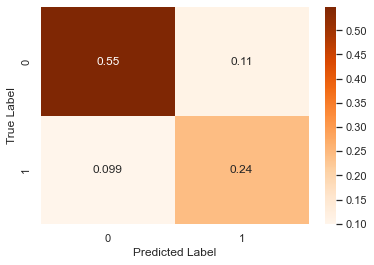

,Metric:,Results:
0,Precision,0.787576
1,Recall,0.710438
2,F1,0.682615
3,Accuracy,0.701216
4,Profitability,58466.960000
5,Profit Percent,64.506006


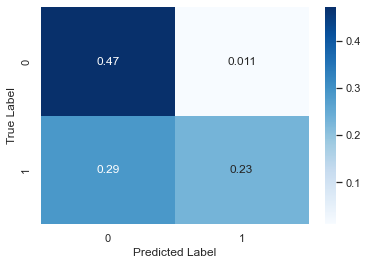

Took 0:01:05.416888 seconds


In [107]:
start_time = time.time()

model = SVC(C= 100, kernel='rbf', gamma = 0.00001)
model.fit(trainX, trainY.to_numpy().flatten())
trainPredict = model.predict(trainX)
cfMatrixTrain = confusion_matrix(trainY, trainPredict)
ax = sns.heatmap(cfMatrixTrain/np.sum(cfMatrixTrain), annot=True, cmap='Oranges')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

testPredict = model.predict(testX)
cfMatrixTest = confusion_matrix(testY, testPredict)

score = model.score(testX, testY)
prec = list(precision_recall_fscore_support(testY, testPredict, average='macro'))
prec[-1] = score


profitTestX = options7put_df.copy()
end = profitTestX.pop('Success')
profitTestX.insert(len(profitTestX.columns), "Success", end)
newColumns = profitTestX.columns

profitTestX = options7put_df.reset_index(drop=True).drop('Success', axis=1)
X_profitability = pd.concat([profitTestX, pd.DataFrame(testPredict)], axis=1, ignore_index=True)
X_profitability.columns = newColumns
X_profitability["Profit"] = X_profitability["Breakeven Price"] - X_profitability["Final Price"]
profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
prec.append(profit)


profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
prec.append(profit_percent)
display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))

ax = sns.heatmap(cfMatrixTest/np.sum(cfMatrixTest), annot=True, cmap='Blues')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

In [149]:
trainX = calls_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1)
trainY = calls_df.filter(['Success'], axis=1)

testX = options7call_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1)
testY = options7call_df.filter(['Success'], axis=1)

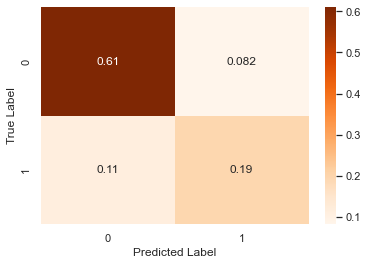

,Metric:,Results:
0,Precision,0.757566
1,Recall,0.824870
2,F1,0.771054
3,Accuracy,0.801758
4,Profitability,-1266.875000
5,Profit Percent,-2.735237


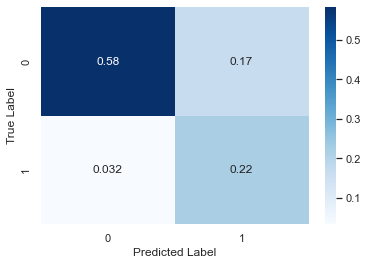

Took 0:00:25.749438 seconds


In [150]:
start_time = time.time()

model = SVC(C= 100, kernel='rbf', gamma = 0.00001)
model.fit(trainX, trainY.to_numpy().flatten())
trainPredict = model.predict(trainX)
cfMatrixTrain = confusion_matrix(trainY, trainPredict)
ax = sns.heatmap(cfMatrixTrain/np.sum(cfMatrixTrain), annot=True, cmap='Oranges')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

testPredict = model.predict(testX)
cfMatrixTest = confusion_matrix(testY, testPredict)

score = model.score(testX, testY)
prec = list(precision_recall_fscore_support(testY, testPredict, average='macro'))
prec[-1] = score


profitTestX = options7call_df.copy()
end = profitTestX.pop('Success')
profitTestX.insert(len(profitTestX.columns), "Success", end)
newColumns = profitTestX.columns

profitTestX = options7call_df.reset_index(drop=True).drop('Success', axis=1)
X_profitability = pd.concat([profitTestX, pd.DataFrame(testPredict)], axis=1, ignore_index=True)
X_profitability.columns = newColumns
X_profitability["Profit"] = X_profitability["Final Price"] - X_profitability["Breakeven Price"]
profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
prec.append(profit)


profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
prec.append(profit_percent)
display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))

ax = sns.heatmap(cfMatrixTest/np.sum(cfMatrixTest), annot=True, cmap='Blues')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

In [142]:
trainX = puts_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1)
trainY = puts_df.filter(['Success'], axis=1)

testX = options7put_df.filter(['Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], axis=1)
testY = options7put_df.filter(['Success'], axis=1)

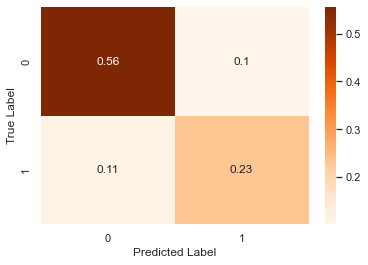

,Metric:,Results:
0,Precision,0.811998
1,Recall,0.776423
2,F1,0.764768
3,Accuracy,0.770226
4,Profitability,99117.375000
5,Profit Percent,58.430326


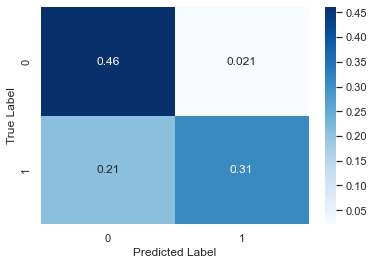

Took 0:01:05.329132 seconds


In [143]:
start_time = time.time()

model = SVC(C= 10, kernel='rbf', gamma = 0.001)
model.fit(trainX, trainY.to_numpy().flatten())
trainPredict = model.predict(trainX)
cfMatrixTrain = confusion_matrix(trainY, trainPredict)
ax = sns.heatmap(cfMatrixTrain/np.sum(cfMatrixTrain), annot=True, cmap='Oranges')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

testPredict = model.predict(testX)
cfMatrixTest = confusion_matrix(testY, testPredict)

score = model.score(testX, testY)
prec = list(precision_recall_fscore_support(testY, testPredict, average='macro'))
prec[-1] = score


profitTestX = options7put_df.copy()
end = profitTestX.pop('Success')
profitTestX.insert(len(profitTestX.columns), "Success", end)
newColumns = profitTestX.columns

profitTestX = options7put_df.reset_index(drop=True).drop('Success', axis=1)
X_profitability = pd.concat([profitTestX, pd.DataFrame(testPredict)], axis=1, ignore_index=True)
X_profitability.columns = newColumns
X_profitability["Profit"] = X_profitability["Breakeven Price"] - X_profitability["Final Price"]
profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
prec.append(profit)


profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
prec.append(profit_percent)
display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))

ax = sns.heatmap(cfMatrixTest/np.sum(cfMatrixTest), annot=True, cmap='Blues')
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")